In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import ctypes
import matplotlib.colors as clr
import matplotlib.pyplot as plt

In [2]:
base_dir = "../social_networks/common_friends/"
#base_dir = "../social_networks/degrees/"
# base_dir = "../data/"

In [3]:

G = nx.read_edgelist(base_dir+"social_network.edgelist", encoding='utf-8', nodetype=int)
#G = nx.convert_node_labels_to_integers(G, first_label=1, ordering="sorted")

In [4]:
df = pd.read_csv(base_dir+"social_network.struc2vec", skiprows=1, sep=' ', header=None, index_col=0).sort_index()
df_train = pd.read_csv(base_dir+"social_network.train", sep=' ', header=None, index_col=0).sort_index()

u_ids = [i for i in df.index if i not in df_train.index]
c_ids = [j for j in df_train[df_train[1] == 1].index]
f_ids = [j for j in df_train[df_train[1] == 0].index]

In [14]:
u_ids = [10]
c_ids = [i for i in df.index if i not in u_ids]

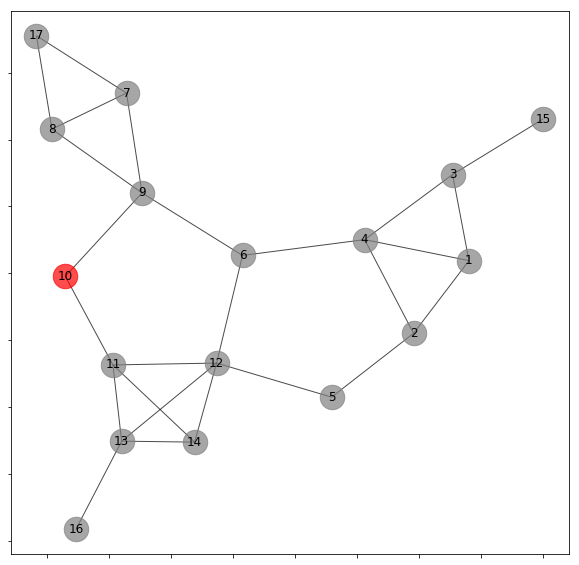

In [15]:

fig, ax1 = plt.subplots(1,1,figsize=(10,10))
#x.draw_kamada_kawai(G,node_color = color_map, label = 'a')
pos=nx.kamada_kawai_layout(G)
# nx.draw_networkx_nodes(G,node_size=600, alpha=0.7, pos=pos, nodelist=u_ids,node_color='red', label=u'Não classificados')
# nx.draw_networkx_nodes(G,node_size=600, alpha=0.7, pos=pos, nodelist=c_ids,node_color='grey', label=u'Confiáveis')
# nx.draw_networkx_nodes(G,node_size=600, alpha=0.7, pos=pos, nodelist=f_ids,node_color='grey', label='Fakes')

nx.draw_networkx_nodes(G,node_size=600, alpha=0.7, pos=pos, nodelist=u_ids,node_color='red')
nx.draw_networkx_nodes(G,node_size=600, alpha=0.7, pos=pos, nodelist=c_ids,node_color='grey')


nx.draw_networkx_edges(G, alpha=0.7, pos=pos)

nx.draw_networkx_labels(G,pos=pos, labels={k+1:v for k,v in enumerate(df.index)})

    
ax1.legend(labelspacing=2, frameon=False)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.savefig('anel-2-comunidades-4.png', transparent=True)
plt.show()

<Figure size 432x288 with 0 Axes>

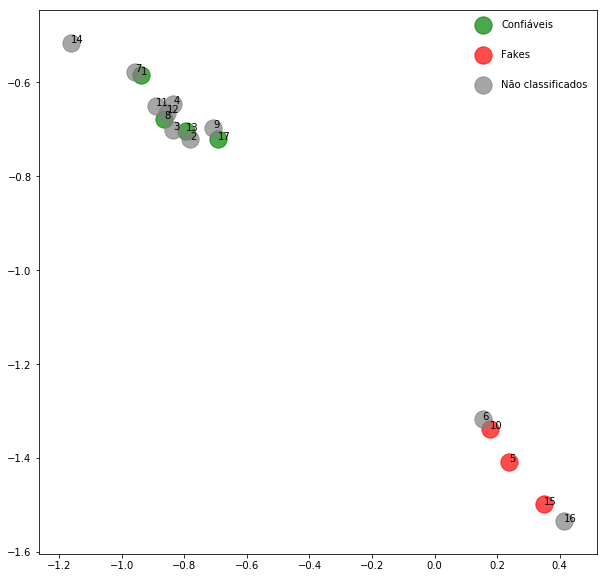

In [20]:
fig, ax1 = plt.subplots(1,1,figsize=(10,10))

groups = np.where(np.isin(df.index, u_ids), 3, np.where(np.isin(df.index, c_ids), 1, 2 ) )
labels= {1: u'Confiáveis', 2: 'Fakes', 3: u'Não classificados'}
cdict = {1: 'green', 2: 'red', 3: 'gray'}
for g in np.unique(groups):
    ix = df[groups == g].index
    ax1.scatter(df.loc[ix,1], df.loc[ix, 2], c = cdict[g], label = labels[g], s = 300, alpha=0.7)
for i in df.index:
    ax1.annotate(i, (df.loc[i,1], df.loc[i, 2]))
# ax1.scatter(df[1][df_train[df_train[1] == 1].index], df[2][df_train[df_train[1] == 1].index], c='green', s=300)
# ax1.scatte r(df[1][df_train[df_train[1] == 0].index], df[2][df_train[df_train[1] == 0].index], c='red', s=300)
# ax1.scatter(df.loc[[i for i in df.index if i not in df_train.index], 1], df.loc[[i for i in df.index if i not in df_train.index], 2], c='gray', s=300)
ax1.legend(labelspacing=2, frameon=False)
plt.show()

In [7]:
#training

In [25]:
df_train.columns = ['confiavel']

In [26]:
df_train = pd.concat([df, df_train], axis=1, join='inner')

In [27]:
y = df_train.loc[:, 'confiavel'].values
X = df_train.drop(['confiavel'], axis=1)

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, class_weight='balanced').fit(X,y)

In [35]:
from sklearn.svm import SVC
C = 0.01
kernel = 'poly'
model = SVC(C=C, random_state=0, kernel=kernel, class_weight='balanced', gamma='scale').fit(X,y)
result = pd.DataFrame(model.predict(df).T, index=df.index).to_dict()[0]

In [37]:
np.unique(result.values())

array([1])

In [144]:
y_pred_proba = lr.predict_proba(df)

In [145]:
threshold = 0.5
y_pred = np.where(y_pred_proba.T[1] > threshold, 1, 0)

In [146]:
# from sklearn.neighbors import KNeighborsClassifier as KNN
# knn = KNN(n_neighbors=7)
# knn.fit(X,y)
# y_pred = knn.predict(df)

In [147]:
c_ids = [j for j in df[y_pred == 1].index]
f_ids = [j for j in df[y_pred == 0].index]

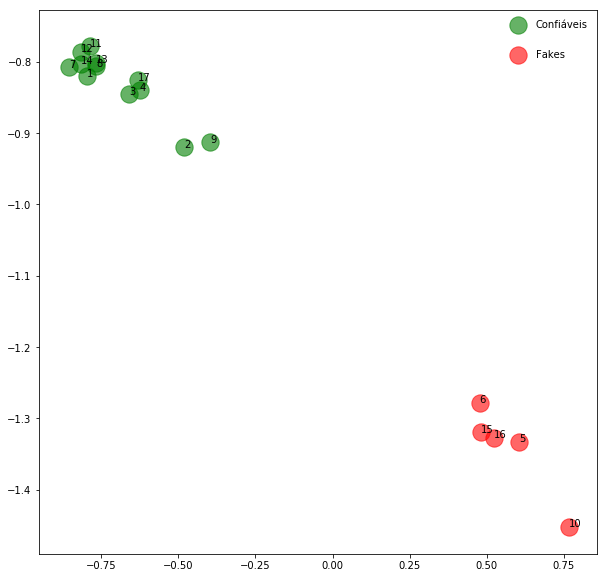

In [148]:
labels= {1: u'Confiáveis', 2: 'Fakes'}
cdict = {1: 'green', 2: 'red'}
groups = np.where(np.isin(df.index, c_ids), 1, 2 )
fig, ax1 = plt.subplots(figsize=(10,10))
#fig.suptitle(u'Classificação de nós por Regressão Logística', fontsize=16)
for g in np.unique(groups):
    ix = df[groups == g].index
    ax1.scatter(df.loc[ix,1], df.loc[ix, 2], c = cdict[g], label = labels[g], s = 300, alpha=0.6)
for i in df.index:
    ax1.annotate(i, (df.loc[i,1], df.loc[i, 2]))
ax1.legend(labelspacing=2, loc='upper right', frameon=False)

plt.show()


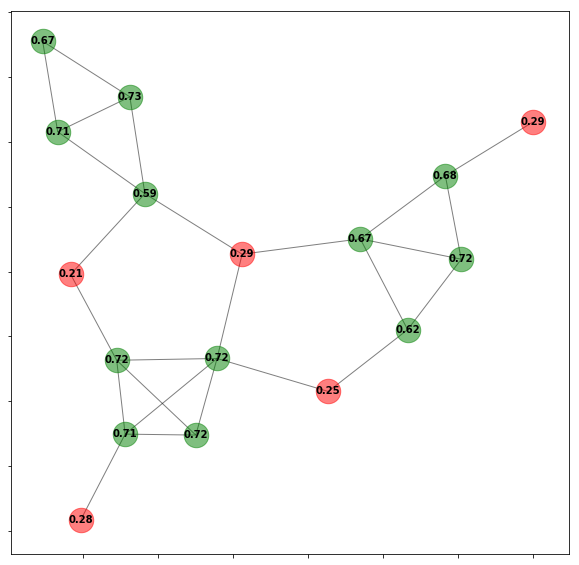

In [149]:
fig, ax1 = plt.subplots(figsize=(10,10))
pos=nx.kamada_kawai_layout(G)
result = {k+1:round(v[1],2) for k,v in enumerate(y_pred_proba)}
nx.draw_networkx_labels(G,pos=pos, labels=result, font_size=10, font_weight='bold')
nx.draw_networkx_nodes(G, node_size=600, alpha=0.5, pos=pos, nodelist=c_ids,node_color='green', label=u'Confiáveis')
nx.draw_networkx_nodes(G, node_size=600, alpha=0.5, pos=pos, nodelist=f_ids,node_color='red', label='Fakes')
nx.draw_networkx_edges(G, alpha=0.5, pos=pos)

#ax1.legend(labelspacing=2, loc='lower right', frameon=False)
ax1.set_yticklabels([])
ax1.set_xticklabels([])


plt.show()

In [150]:
cmap = clr.LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ff0000'),
                                              (1, '#00ff00')], N=256)

In [151]:
y_pred_proba

array([[0.28409003, 0.71590997],
       [0.38237721, 0.61762279],
       [0.32383935, 0.67616065],
       [0.3330778 , 0.6669222 ],
       [0.74526027, 0.25473973],
       [0.70870986, 0.29129014],
       [0.26794333, 0.73205667],
       [0.29104231, 0.70895769],
       [0.40796481, 0.59203519],
       [0.78991369, 0.21008631],
       [0.28404918, 0.71595082],
       [0.27676451, 0.72323549],
       [0.29035074, 0.70964926],
       [0.27764803, 0.72235197],
       [0.71303862, 0.28696138],
       [0.72407644, 0.27592356],
       [0.33007609, 0.66992391]])

[]

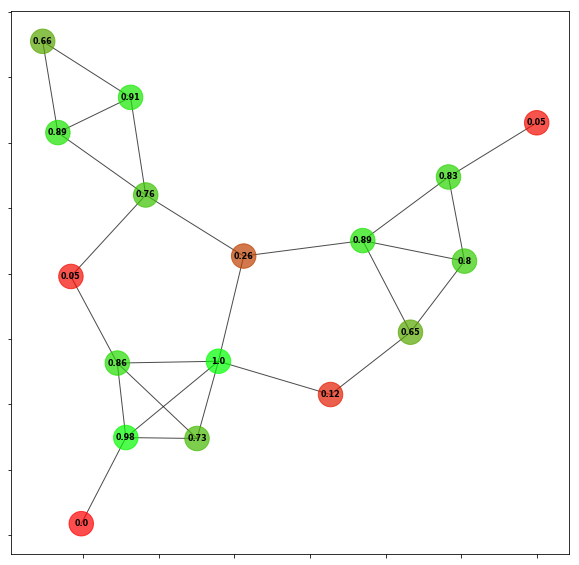

In [152]:
result = pd.read_csv(base_dir+"social_network.realrank", sep=' ', header=None, index_col=0).sort_index()
labels = {k+1:round(v,2) for k,v in enumerate(result.values.ravel().T)}
node_color = result.to_dict()[1]


fig, ax1 = plt.subplots(figsize=(10,10))
#fig.suptitle(u'Resultados após propagação por SybilRank', fontsize=16)
pos=nx.kamada_kawai_layout(G)
nx.draw_networkx_labels(G,pos=pos, labels=labels, font_size=8, font_weight='bold')
nx.draw_networkx_nodes(G,node_size=600, alpha=0.7, cmap=cmap, pos=pos, vmin=0, vmax=1, node_color=[v for k,v in node_color.items()])
nx.draw_networkx_edges(G,node_size=600, alpha=0.7, pos=pos)
ax1.legend(labelspacing=2, loc='lower right', frameon=False)
ax1.set_yticklabels([])
ax1.set_xticklabels([])


In [153]:
#rw simulator
G=nx.DiGraph()
edges = [
    (1,2, {'weight':0.2}),
    (1,3, {'weight':0.4}),
    (1,4, {'weight':0.4}),
    (2,4, {'weight':0.4}),
    (2,6, {'weight':0.6}),
    (3,6, {'weight':1.0}),
    (4,7, {'weight':0.7}),
    (4,5, {'weight':0.3}),
    (5,2, {'weight':1.0}),
    (6,5, {'weight':1.0}),
    (7,5, {'weight':1.0})
]
G.add_edges_from(edges)
labels_e = nx.get_edge_attributes(G,'weight')
pos=nx.layout.kamada_kawai_layout(G)

{1: Text(0.116474,-0.122241,'1'),
 2: Text(-0.0541795,-0.184101,'2'),
 3: Text(0.447175,-0.447296,'3'),
 4: Text(-0.076822,0.269471,'4'),
 5: Text(-0.40656,0.314685,'5'),
 6: Text(-0.311089,-0.830518,'6'),
 7: Text(0.285003,1,'7')}

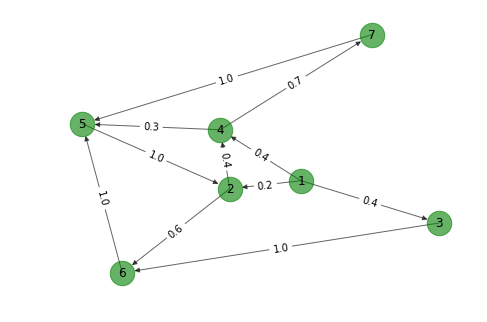

In [154]:
nx.draw(G, pos=pos, node_color='green', alpha=0.6, node_size=600)
nx.draw_networkx_edge_labels(G, edge_labels=labels_e, pos=pos,)
nx.draw_networkx_labels(G, pos=pos)